In [1]:
%load_ext autoreload 
%autoreload 2

In [2]:
import os
os.sys.path.append('../..')
from qincm.qincm import QINCM
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import ipywidgets as widgets
from ipywidgets import interact, interactive, fixed, interact_manual
import json
import copy

In [13]:
inputdir = Path('../0_preprocessing/preprocessing_KBN_v0.1')
outputdir = Path('KBN_v0.1')

In [74]:
route_depth_costs_file = inputdir / 'route_depth_costs.json'
knelpunt_discharge_depth_file = inputdir / 'knelpunt_discharge_waterdepth.json'
reference='BR_Lobith'

In [133]:
# Read years of average and return periods
Q_year = pd.read_excel(example_dir / 'Average.xlsx', index_col=0)['Ref']

CDF = pd.read_excel(example_dir / 'CDF.xlsx', index_col=0, header=[0, 1])

# Mirror levels they were meant for overschrijdingsduur (not onderschrijdingsduur)
CDF = CDF.rename(columns={ 
    1: 'T100', # 100 of 100
    2: 'T2', # 50 of 100 years
#     10: 'T10', # 10 of 100 years 
#     50: 'T2', # 2 of 100 years
    100: 'T1' # 1 of 100
}).drop([10, 50], axis=1, level=-1)

In [275]:
def inverselegend(outside=False, **kwargs):
    if outside:
        return plt.gca().legend(*map(reversed, plt.gca().get_legend_handles_labels()), loc='center left',
                         bbox_to_anchor=(1, 0.5), **kwargs)
    else:
        return plt.gca().legend(*map(reversed, plt.gca().get_legend_handles_labels()), **kwargs)

In [272]:
# Reference model for all simulations below
M = QINCM(
    route_depth_costs_file,
    knelpunt_discharge_depth_file,
    reference=reference
)


def compute_costs_T(M):
    dt = (Q_year.index[0] - Q_year.index[1]) * 365

    scenario_results = {}
    scenario_results['Gemiddeld'] = M.costs_for_scenario(Q_year.values, dt, delta=True).sum()
    
    for T in ['T1', 'T2', 'T100']:
        dt = (CDF.index[0] - CDF.index[1]) * 365
        scenario_results[f'{T}'] = M.costs_for_scenario(CDF[('Ref', T)].values, dt, delta=True).sum()

    scenario_results = pd.Series(scenario_results)
    return scenario_results

scenario_results_ref = compute_costs_T(M)

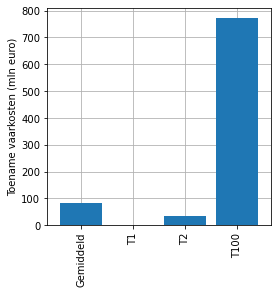

In [282]:
def plot_results(scenario_results, ax):
    plt.sca(ax)
    (scenario_results / 1e6).plot.bar(width=0.8, zorder=3, stacked=True, cmap='tab20', ax=ax, legend=False)
    plt.grid()
    plt.ylabel('Toename vaarkosten (mln euro)')
    
f, ax = plt.subplots(figsize=(4,4))
plot_results(scenario_results_ref, ax)
plt.savefig(outputdir / 'Kosten_per_jaar.png', bbox_inches='tight', dpi=150)

In [421]:
dt = (Q_year.index[0] - Q_year.index[1]) * 365


def compute_costs(M):
#     Q_costs = np.linspace(500, 13000, 10)
#     C = M.costs_per_discharge(Q_costs).T
    
    C = M.costs_for_scenario(Q_year.values, dt, delta=False).sum()
    
    return C
    
# Reference model for all simulations below
M = QINCM(
    route_depth_costs_file,
    knelpunt_discharge_depth_file,
    reference=reference
)

scenario_results_ref = compute_costs(M)
scenario_results_ref

2410777270.110779

In [316]:
with open(knelpunt_discharge_depth_file) as fin:
    Q_VD_ref = json.load(fin)
    
knelpunten = Q_VD_ref.keys()

scenario_results_adjusted_h = {}
for dh in np.arange(-5, 6, 1) / 10:
    print(dh)
    scenario_results_adjusted = {}
    for k in knelpunten:
        Q_VD = copy.deepcopy(Q_VD_ref)
        for q in Q_VD[k].keys():
            Q_VD[k][q] += dh

        M._read_knelpunt_discharge_depth(Q_VD, reference=reference)

        scenario_results_adjusted[k] = compute_costs(M)

    scenario_results_adjusted_h[dh] = pd.Series(scenario_results_adjusted)
scenario_results_adjusted_h = pd.concat(scenario_results_adjusted_h)
    

-0.5
-0.4
-0.3
-0.2
-0.1
0.0
0.1
0.2
0.3
0.4
0.5


In [318]:
scenario_results_adjusted_h = scenario_results_adjusted_h.unstack() - scenario_results_ref

In [319]:
besparing = scenario_results_adjusted_h.loc[-0.05:0.5].T
besparing_plot = -besparing.diff(axis=1) / 1e6

besparing_plot = besparing_plot.fillna(0)

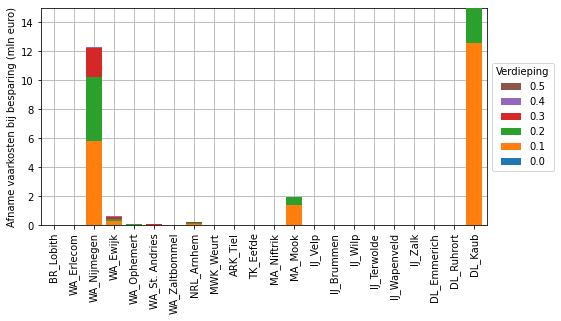

In [322]:
besparing_plot.plot.bar(stacked=True, zorder=3, figsize=(8, 4), width=0.8)
plt.ylim(0, 1.5e1)
plt.ylabel('Afname vaarkosten bij besparing (mln euro)')
plt.grid()
inverselegend(outside=True, title='Verdieping (m)')
plt.savefig(outputdir / 'Verdieping 1 knelpunt.png', bbox_inches='tight', dpi=150)

Text(0, 0.5, 'Afname vaarkosten bij verdieping (mln euro)')

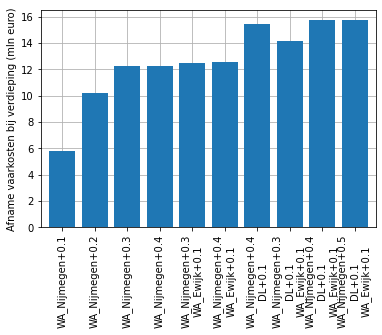

In [426]:
def effect_correct_depth( **knelpunten):
    Q_VD = copy.deepcopy(Q_VD_ref)
    for k, dh in knelpunten.items():
        for q in Q_VD[k].keys():
            Q_VD[k][q] += dh
        
    M._read_knelpunt_discharge_depth(Q_VD, reference=reference)
        
    scenario_results = scenario_results_ref - M.costs_for_scenario(Q_year.values, dt, delta=False).sum()    
    return scenario_results

# automated version below
# sim = pd.Series({
#     'WA_Nijmegen+0.1': effect_correct_depth(WA_Nijmegen=0.1),
#     'WA_Nijmegen+0.2': effect_correct_depth(WA_Nijmegen=0.2),
#     'WA_Nijmegen+0.3': effect_correct_depth(WA_Nijmegen=0.3),
#     'WA_Nijmegen+0.4': effect_correct_depth(WA_Nijmegen=0.4),
#     'WA_Nijmegen+0.3\nWA_Ewijk+0.1': effect_correct_depth(WA_Nijmegen=0.3, WA_Ewijk=0.1),
#     'WA_Nijmegen+0.4\nWA_Ewijk+0.1': effect_correct_depth(WA_Nijmegen=0.4, WA_Ewijk=0.1),
#     'WA_Nijmegen+0.4\nDL+0.1': effect_correct_depth(WA_Nijmegen=0.4, DL_Emmerich=0.1, DL_Ruhrort=0.1),
#     'WA_Nijmegen+0.3\nDL+0.1\nWA_Ewijk+0.1': effect_correct_depth(WA_Nijmegen=0.3, DL_Emmerich=0.1, DL_Ruhrort=0.1, WA_Ewijk=0.1),
#     'WA_Nijmegen+0.4\nDL+0.1\nWA_Ewijk+0.1': effect_correct_depth(WA_Nijmegen=0.4, DL_Emmerich=0.1, DL_Ruhrort=0.1, WA_Ewijk=0.1),
#     'WA_Nijmegen+0.5\nDL+0.1\nWA_Ewijk+0.1': effect_correct_depth(WA_Nijmegen=0.5, DL_Emmerich=0.1, DL_Ruhrort=0.1, WA_Ewijk=0.1),
# }) / 1e6


# sim.plot.bar(width=0.8, zorder=3)
# plt.grid()
# plt.ylabel('Afname vaarkosten bij verdieping (mln euro)')

In [429]:
scenarios = pd.read_csv('knelpunten_oplos_scenarios.csv', header=None, index_col=0).fillna(0)

scenario_results = {}
for name, s in scenarios.T.iterrows():
    scenario_results[name] = effect_correct_depth(**s)

scenarios_export = scenarios.copy()
scenarios_export.loc['costs decrease'] = scenario_results
scenarios_export.to_csv(outputdir / 'Scenarios knelpunten.csv')

In [430]:
alltrips, mintrips = M.stats_knelpunten()

Text(0.5, 1.0, 'Kosten per maatgevende knelpunt')

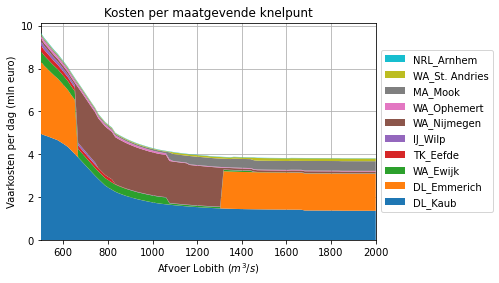

In [431]:
plotdata2 =mintrips.fillna(0)
plotdata2= plotdata2 / 1e6
# plotdata2 = plotdata2 - plotdata2.loc[2000]
plotdata2 = plotdata2.sort_values(axis=1, by=500, ascending=False)
pc = plt.stackplot(plotdata2.index, plotdata2.T[:10], labels=plotdata2.columns[:10], zorder=3)
plt.legend(plotdata2.columns)
plt.grid()
plt.xlim(plotdata2.index[0], plotdata2.index[-1])
inverselegend(outside=True)
plt.xlabel(f'Afvoer Lobith ($m^3/s$)')
plt.ylabel('Vaarkosten per dag (mln euro)')
plt.title('Kosten per maatgevende knelpunt')

# plt.savefig(outputdir / 'Knelpunten_cum_costs.png', dpi=300, bbox_inches='tight')

In [432]:
# plotdata = alltrips - alltrips.loc[2000]
# maxtrips = alltrips.loc[500]
# plotdata_normed = plotdata / maxtrips
# plotdata2 = mintrips - alltrips.loc[2000]
# plotdata2_normed = plotdata2 / maxtrips


# f, ax = plt.subplots(6, 4, sharex=True, sharey=True, figsize=(10,10))
# plt.subplots_adjust(hspace=0.3)
# ax = ax.flatten()

# knelpunten = mintrips.columns
# for ii, name in enumerate(M.knelpunt_names):
#     data = plotdata2_normed[name]
#     plt.sca(ax[ii])
#     plt.title(name)
#     plt.fill_between(data.index, data.values)
#     plt.annotate('{:.1f}'.format(maxtrips[name]), (0.95, 0.95), color='w', xycoords='axes fraction', ha='right', va='top')
#     ax[ii].set_facecolor('C3')
#     plotdata_normed[name].plot(ax=ax[ii], ls=':', c='k')
# plt.xlim(plotdata2.index[0], plotdata2.index[-1])
# plt.ylim(0, 1)
# plt.xlabel(f'Afvoer Lobith ($m^3/s$)')

# # ax[ii+1].set_axis_off()
# # ax[ii+2].set_axis_off()

# plt.gca().set_yticklabels(['{:.0f}%'.format(x*100) for x in plt.gca().get_yticks()]);

# # plt.savefig(outputdir / 'Knelpunten_perc_reizen_beinvloed_Q.png', dpi=300, bbox_inches='tight')